In [5]:
import xgboost as xgb

In [6]:
# 读取数据
dtrain = xgb.DMatrix('agaricus.txt.train.txt')
dtest = xgb.DMatrix('agaricus.txt.test.txt')
# 通过 map 指定参数
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# 预测
preds = bst.predict(dtest)

[09:40:11] 6513x127 matrix with 143286 entries loaded from agaricus.txt.train.txt
[09:40:11] 1611x127 matrix with 35442 entries loaded from agaricus.txt.test.txt


In [7]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR'])


In [8]:
print(boston.data.shape)
print(boston.feature_names)
print(boston.target.shape)
# print(boston.DESCR)

(506, 13)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
(506,)


In [9]:
import pandas as pd

data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [10]:
data['PRICE'] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [11]:
X, y = data.iloc[:,:-1],data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)

## XGBoost's hyperparameters
At this point, before building the model, you should be aware of the tuning parameters that XGBoost provides. Well, there are a plethora of tuning parameters for tree-based learners in XGBoost and you can read all about them here. But the most common ones that you should know are:

- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- n_estimators: number of trees you want to build.
- objective: determines the loss function to be used like 
      reg:linear for regression problems, 
      reg:logistic for classification problems with only decision,
      binary:logistic for classification problems with probability.
  
XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- alpha: L1 regularization on leaf weights. A large value leads to more regularization.
- lambda: L2 regularization on leaf weights and is smoother than L1 regularization. 

- booster:
It's also worth mentioning that though you are using trees as your base learners, you can also use XGBoost's relatively less popular linear base learners and one other tree learner known as dart. All you have to do is set the booster parameter to either gbtree (default),gblinear or dart.

Now, you will create the train and test set for cross-validation of the results using the train_test_split function from sklearn's model_selection module with test_size size equal to 20% of the data. Also, to maintain reproducibility of the results, a random_state is also assigned.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [13]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 10.231681


## k-fold Cross Validation using XGBoost
In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. Also, it supports many other parameters (check out this link) like:

- num_boost_round: denotes the number of trees you build (analogous to n_estimators)
- metrics: tells the evaluation metrics to be watched during CV
- as_pandas: to return the results in a pandas DataFrame.
- early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
- seed: for reproducibility of results.

This time you will create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs but will exclude the n_estimators from the hyper-parameter dictionary because you will use num_boost_rounds instead.

You will use these parameters to build a 3-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. Note that here you are using the Dmatrix object you created before.

In [15]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned no

[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[09:40:11] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 prun

In [16]:
print(cv_results.shape)
cv_results.head()

(50, 4)


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.747809,0.031729,21.765166,0.029215
1,19.784218,0.058710,19.792527,0.048540
2,18.026065,0.049725,18.031417,0.085975
3,16.453807,0.075936,16.515289,0.111829
4,15.026489,0.070248,15.146503,0.119410


## Visualize Boosting Trees and Feature Importance
You can also visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset. XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

In [17]:
import matplotlib.pyplot as plt
import graphviz
# 需要安装 Graphviz安装包
# https://graphviz.gitlab.io/_pages/Download/Download_windows.html

import os
os.environ["PATH"] += os.pathsep + 'c:/Program Files (x86)/Graphviz2.38/bin/'
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[09:40:12] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:40:12] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:40:12] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[09:40:12] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[09:40:12] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:40:12] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[09:40:12] d:\build\xgboost\xgboost-0.80.git\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned 

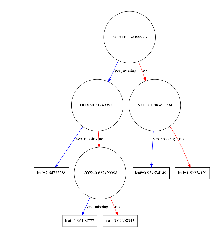

In [18]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50,10]
plt.show()

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this.

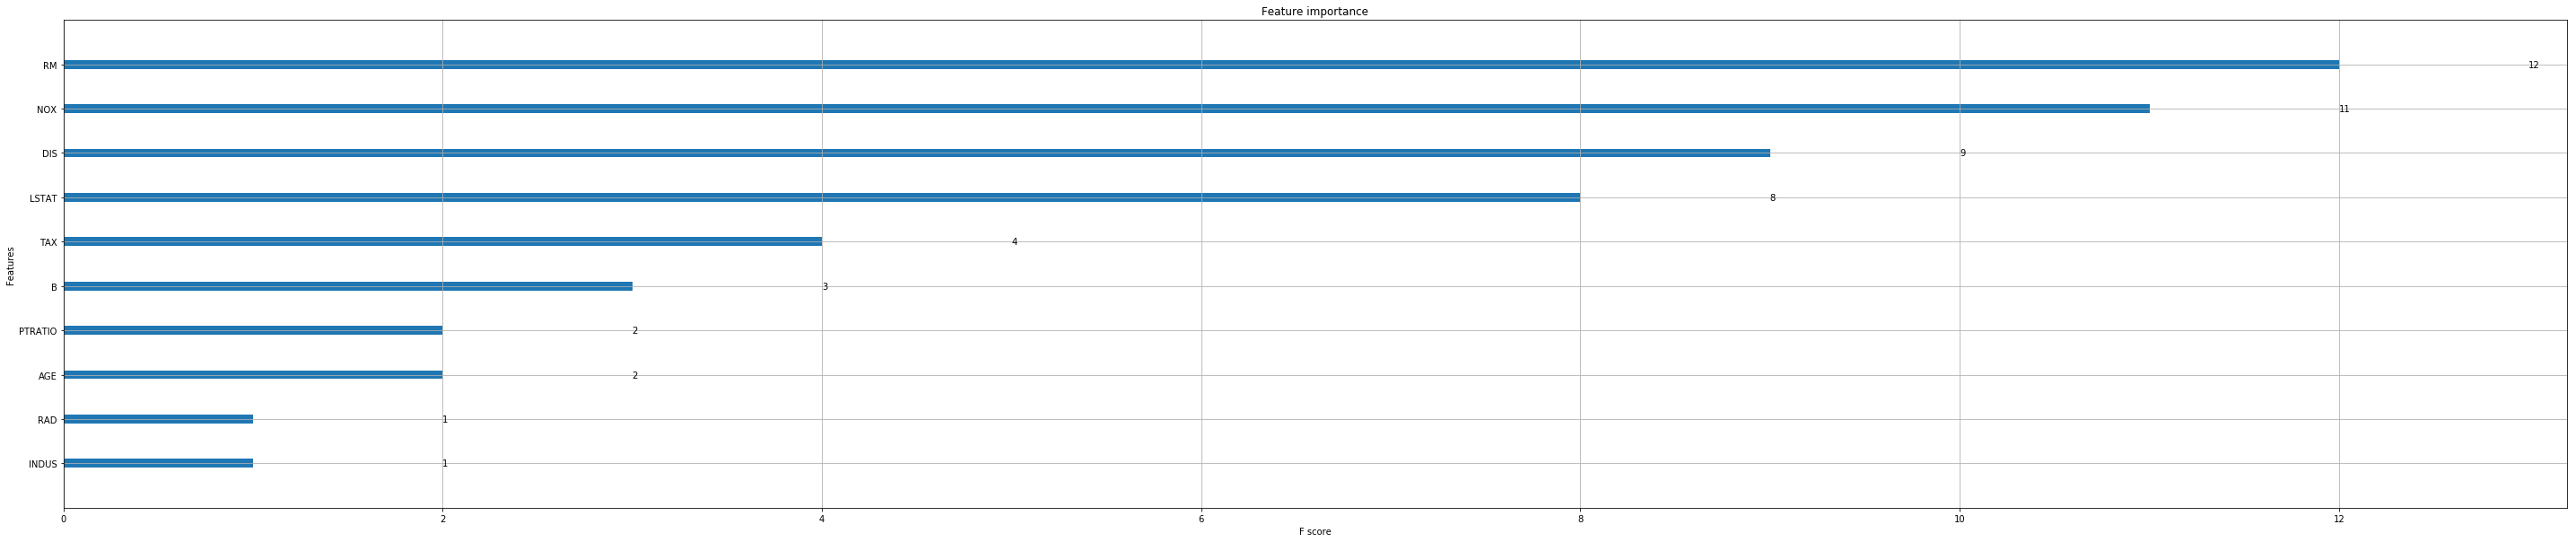

In [19]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()